In [1]:
SEED = 9

import os
os.environ['PYTHONHASHSEED'] = str(SEED)

import random
random.seed(SEED)

import numpy as np
rng = np.random.default_rng(SEED) 
ss = rng.bit_generator._seed_seq # use for multiprocessing


SEED_states_log = []


# -------------------------------------------------------------------------------


import warnings
warnings.simplefilter(action='ignore')
np.seterr(divide = 'ignore')
# np.seterr(divide = 'warn')


import datetime
import random
import time
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from alpha_vantage.timeseries import TimeSeries
from deap import base
from deap import creator
from deap import tools
from tqdm import trange
from pathlib import Path
import pyfolio as pf

              open    high     low   close  Ceres_declination  \
timestamp                                                       
2013-12-27  763.28  777.51  713.60  735.07           1.494156   
2013-12-28  737.98  747.06  705.35  727.83           1.416734   
2013-12-29  728.05  748.61  714.44  745.05           1.341087   
2013-12-30  741.35  766.60  740.24  756.13           1.267234   
2013-12-31  760.32  760.58  738.17  754.01           1.195193   

            Ceres_longitude  Ceres_latitude  Ceres_distance  Ceres_speed  
timestamp                                                                 
2013-12-27       200.436626       10.216835        2.644029     0.322382  
2013-12-28       200.757466       10.260102        2.631780     0.319286  
2013-12-29       201.075182       10.303746        2.619493     0.316130  
2013-12-30       201.389709       10.347768        2.607171     0.312908  
2013-12-31       201.700978       10.392166        2.594816     0.309616  


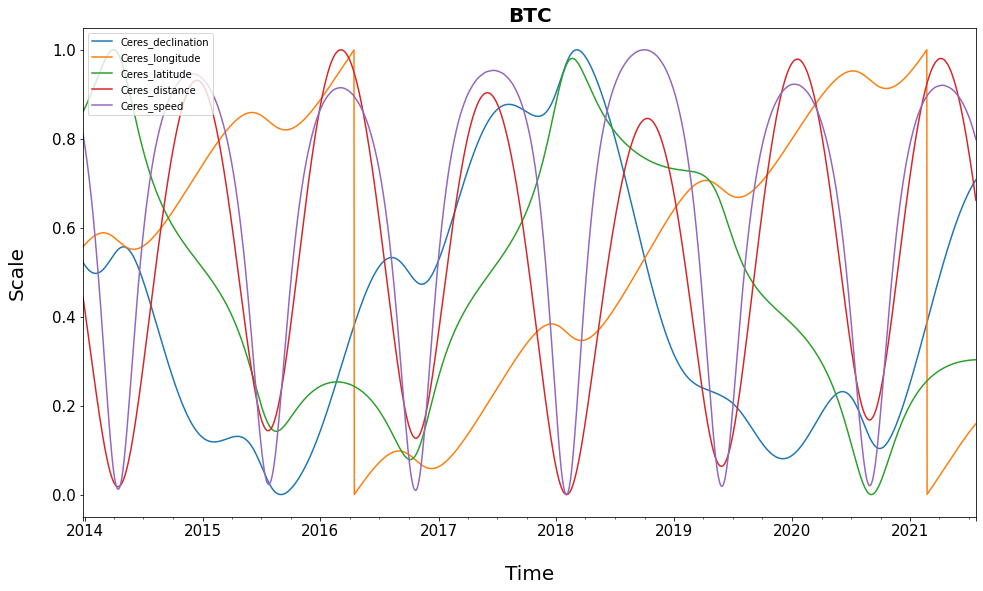

In [2]:
ticker = "BTC"


def min_max_scaling(df):
    # copy the dataframe
    tdf = df.copy()
    # apply min-max scaling
    for column in tdf.columns:
        tdf[column] = (tdf[column] - tdf[column].min()) / (tdf[column].max() - tdf[column].min())
#     tdf = tdf.dropna(axis='columns')
    tdf = tdf.fillna(0)
    return tdf

def get_df(ticker,return_len=None,loc=1):
    
    if loc == 1:
        path = '///'
        file = ticker + '.csv'
        url = path + file
        df = pd.read_csv(url,parse_dates=True,index_col=0)
        
    if loc == 2:
        path = '///'
        file = "_" + ticker + ".csv"
        url = path + file
        df = pd.read_csv(url,parse_dates=True,index_col=0)
        

    if return_len == True:
        return df.tail(return_len)
    else:
        return df


df = get_df(ticker,loc=2)

df = df.rename(
    columns={
        "Ceres declination": "Ceres_declination",
        "Ceres longitude": "Ceres_longitude",
        "Ceres latitude": "Ceres_latitude",
        "Ceres distance": "Ceres_distance",
        "Ceres speed": "Ceres_speed",
    }
)


xc = ["open", "high", "low", "close"]

cols = list(filter(lambda i: i not in xc , df.columns))

cdf = df[cols]

cdf = min_max_scaling(cdf)


fig, ax = plt.subplots(figsize=(16,9))
for c in cdf.columns:
    cdf[c].plot(xlabel="\nTime", ylabel="Scale\n", ax=ax)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title(ticker, fontsize=20, fontweight="bold")
ax.legend(loc="upper left")

# print(df.head(),0.7*len(df))

# train = df.iloc[:1936]
# test = df.iloc[1936:]


# print(train)
# print(test)


print(df.head())

In [4]:
class PandasData(bt.feeds.PandasData):
    lines = ('Ceres_declination',)
    params = (
        ('datetime', None),
        ('open','open'),
        ('high','high'),
        ('low','low'),
        ('close','close'),
        ('volume', None),
        ('openinterest',None),
        ('Ceres_declination','Ceres_declination'),
    )



bt_data=PandasData(dataname=df)


Starting Portfolio Value: 10,000.00
Final Portfolio Value:    11,451.72


<IPython.core.display.Javascript object>


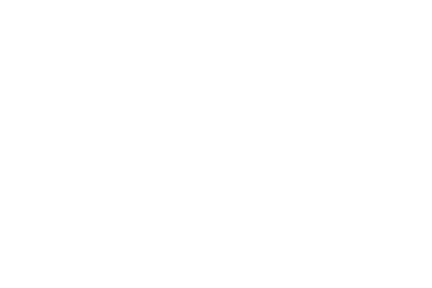

Start date,2013-12-27
End date,2021-07-23
Total months,131
,Backtest
Annual return,1.243%
Cumulative returns,14.517%
Annual volatility,854.055%
Sharpe ratio,-0.37
Calmar ratio,0.01
Stability,NaN
Max drawdown,-138.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,138.2,2017-07-16,2017-12-16,2019-06-25,507
1,47.29,2020-02-14,2021-06-29,NaT,NaN
2,24.96,2019-06-26,2019-07-16,2020-02-12,166
3,4.57,2016-08-02,2017-01-11,2017-03-03,154
4,4.05,2017-06-11,2017-06-15,2017-07-01,15


Stress Events,mean,min,max
Apr14,0.00%,0.00%,0.00%
Oct14,0.00%,0.00%,0.00%
Fall2015,0.01%,-0.16%,0.47%
New Normal,-1.25%,-2378.59%,753.20%


Top 10 long positions of all time,max
Data0,8327.54%


Top 10 short positions of all time,max
Data0,-185530.51%


Top 10 positions of all time,max
Data0,185530.51%


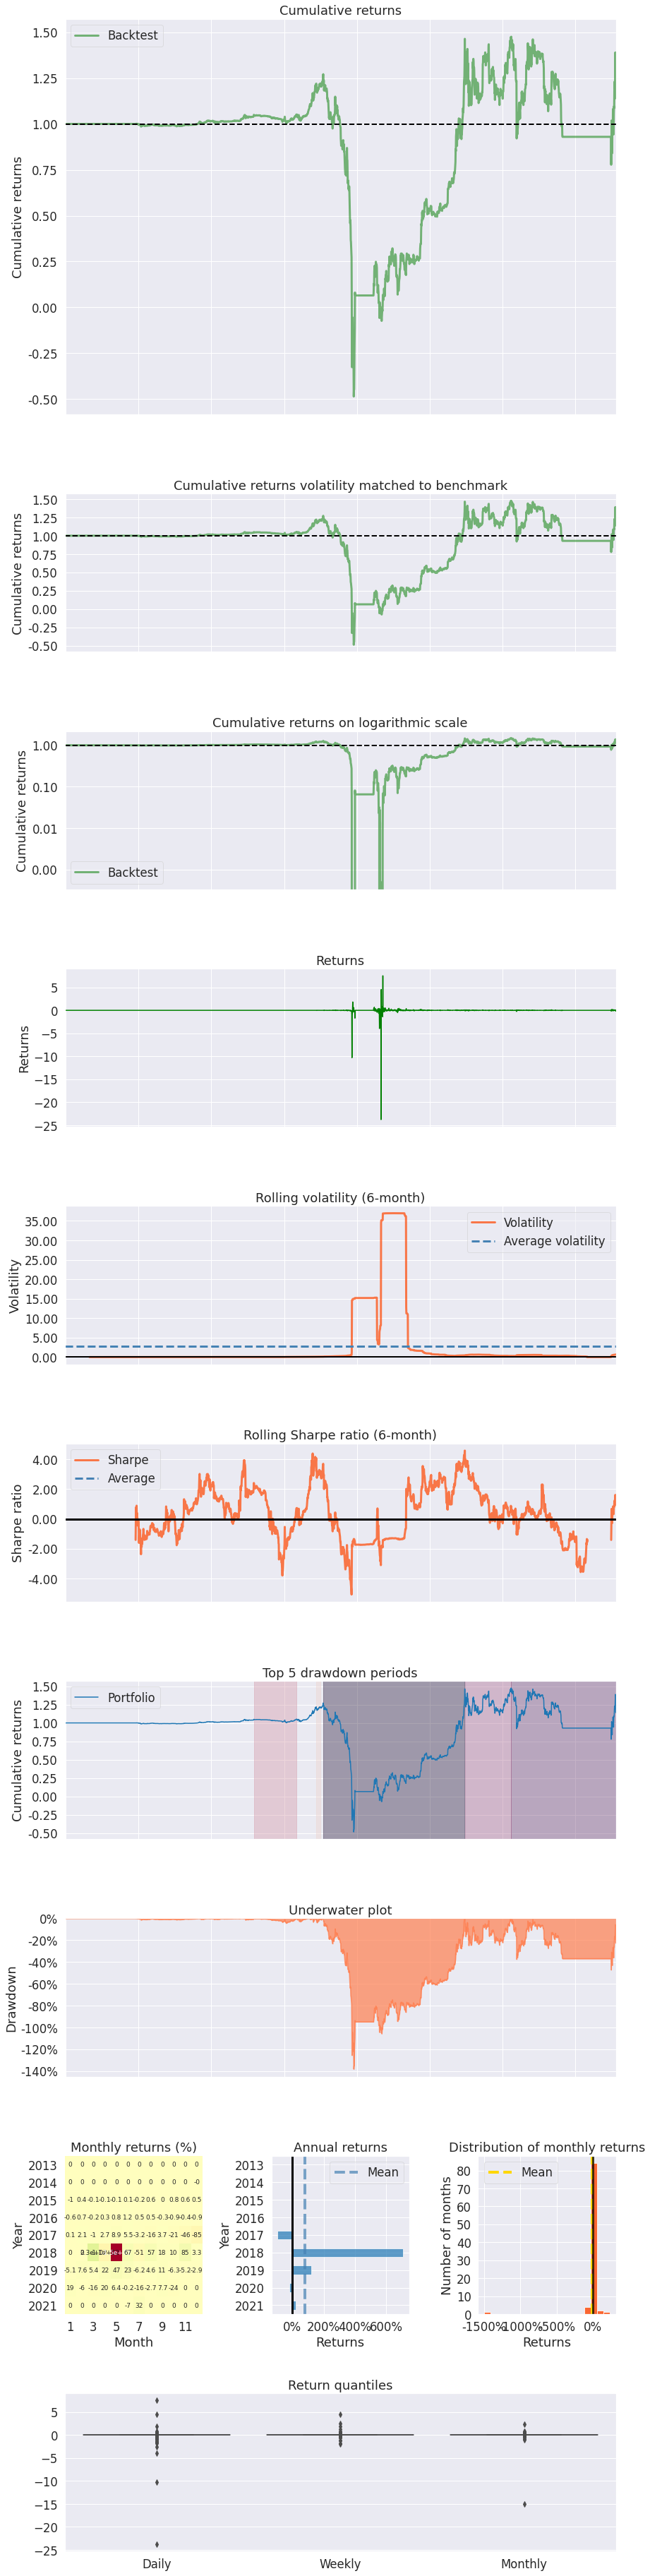

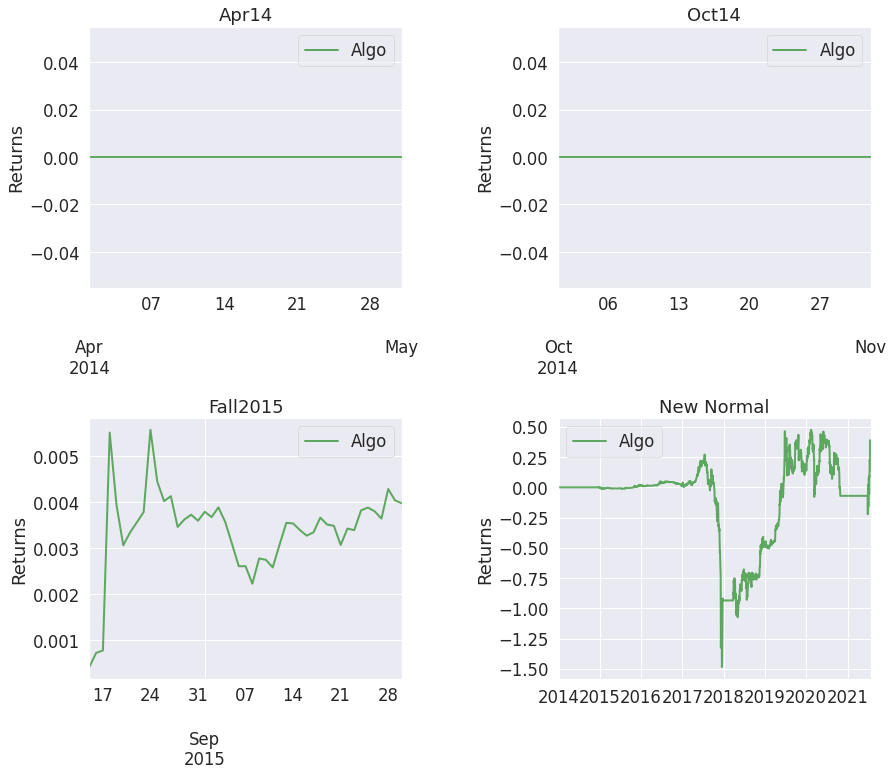

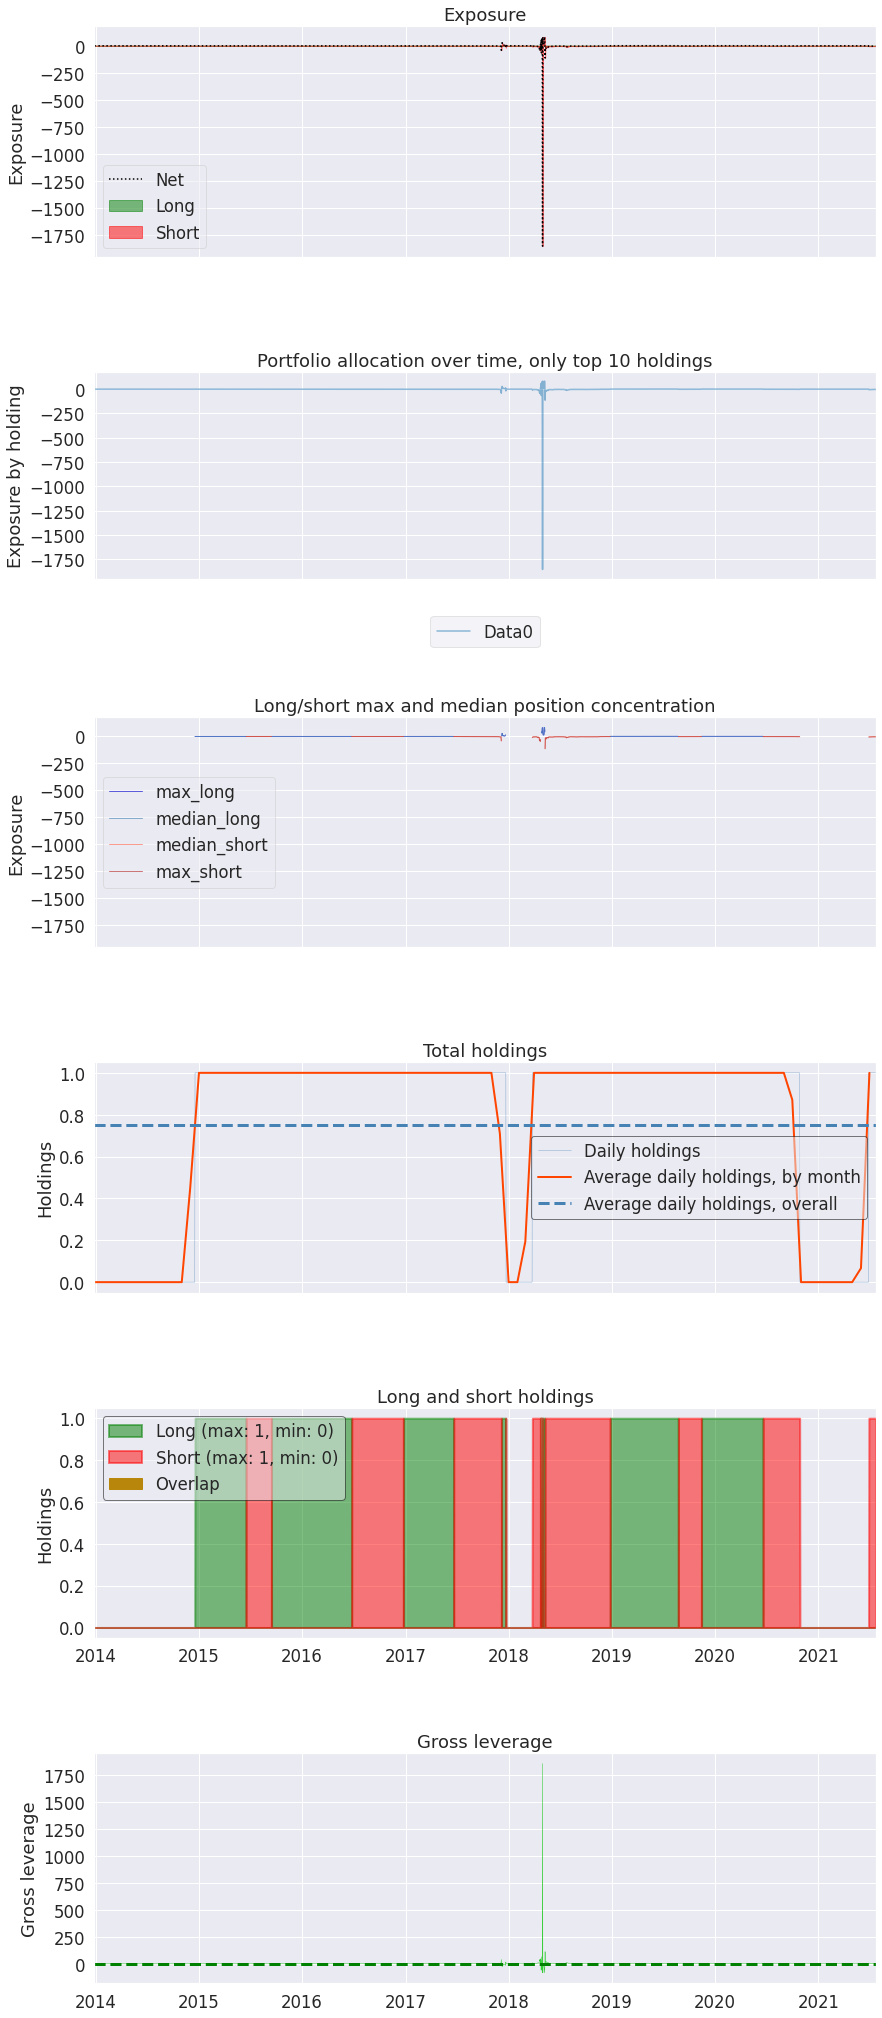

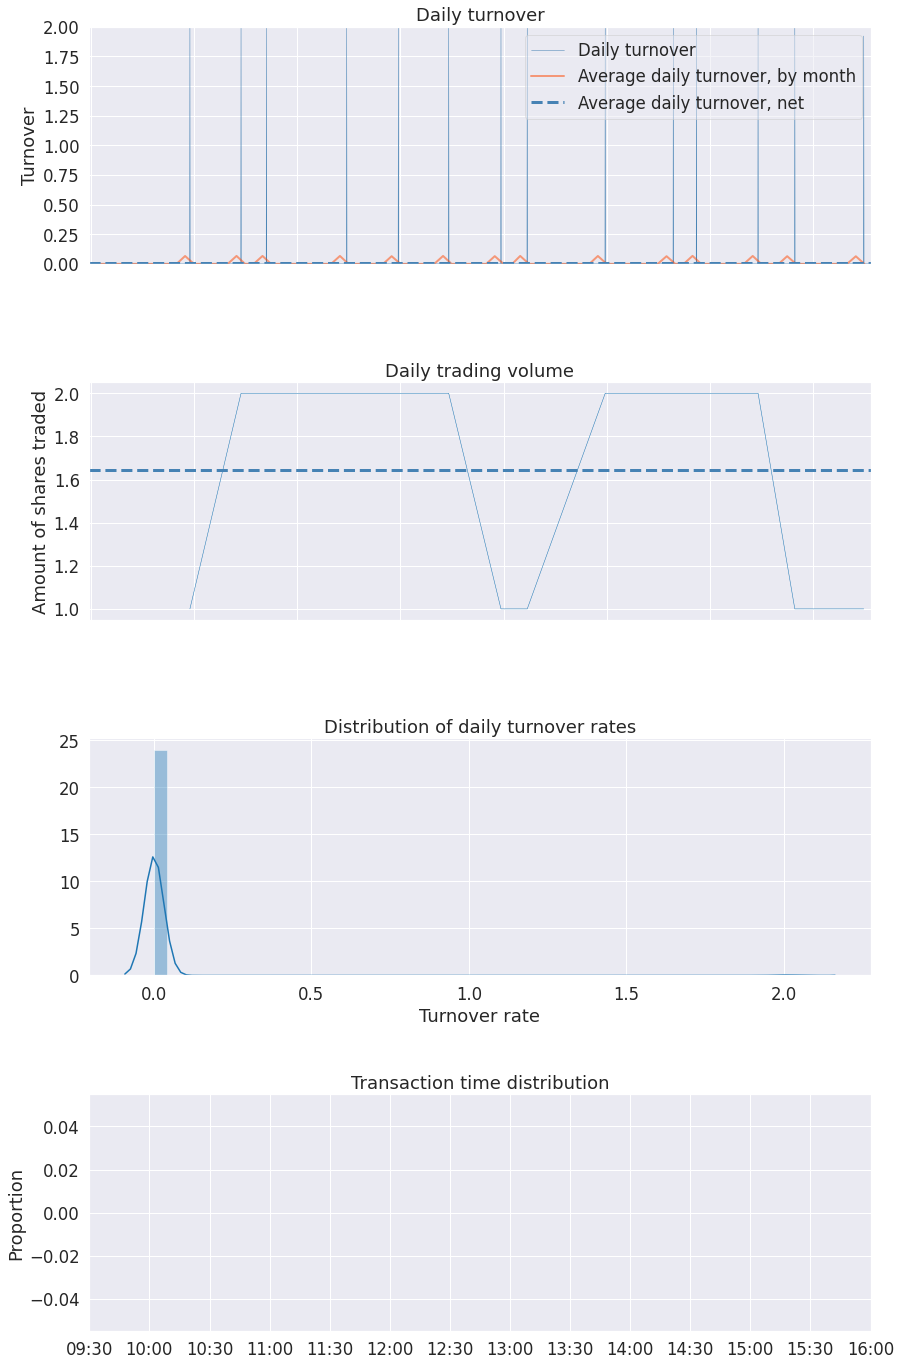

In [7]:
class CrossoverStrategy(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(fast_period=29, slow_period=144, signal_period=82)

    def __init__(self):
    
        
#         print(dir(self.data.Ceres_declination))
        self.fast_ma = bt.indicators.EMA(self.data.Ceres_declination, period=self.p.fast_period)
        self.slow_ma = bt.indicators.EMA(self.data.Ceres_declination, period=self.p.slow_period)        
        self.macd_line = self.fast_ma - self.slow_ma
        self.signal_line = bt.indicators.EMA(self.macd_line, period=self.p.signal_period)
        self.macd_crossover = bt.indicators.CrossOver(self.macd_line, self.signal_line)
        

    def next(self):

        if self.macd_crossover > 0:
            self.close()  # close short position
            self.buy()  # enter long position
        elif self.macd_crossover < 0:
            self.close()  # close long position
            self.sell()  # enter short position
            
            

STRATEGY_PARAMS = dict(fast_period=29, slow_period=144, signal_period=82)
#-----------------------------------------------------------------------------------------------------------


def run_backtest(plot=True, **strategy_params):
    
    rng = np.random.default_rng(SEED) 

    cerebro = bt.Cerebro()
    

    cerebro.adddata(bt_data)
#     cerebro.adddata(
#         bt.feeds.PandasData(dataname=df)
#     )

    # Remember to set it high enough or the strategy may not
    # be able to trade because of short of cash
    cerebro.broker.setcash(10000.0)

    # Print out the starting conditions
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():,.2f}")

    # Although we have defined some default params in the strategy,
    # we can override it by passing in keyword arguments here.
    cerebro.addstrategy(CrossoverStrategy, **strategy_params)

    cerebro.addobserver(bt.observers.Trades)
    cerebro.addobserver(bt.observers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio)
    
    cerebro.addanalyzer(bt.analyzers.PyFolio)

    # Let's say that we have 0.25% slippage and commission per trade,
    # that is 0.5% in total for a round trip.
    cerebro.broker.setcommission(commission=0.003, margin=False)

    # Run over everything
    strats = cerebro.run(tradehistory=True)

    pyfoliozer = strats[0].analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

    print(f"Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}")

    if plot:
        cerebro.plot(volume=False)
        
    %matplotlib inline
    

    pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
#     live_start_date='2005-05-01',  # This date is sample specific
#     round_trips=True
    )


run_backtest(**STRATEGY_PARAMS)
#-----------------------------------------------------------------------------------------------------------



In [ ]:
# split our data into training set and testing set

# let's look at how many rows of data we have got
df = df
print(df.shape, df.index.min().date(), df.index.max().date())

# let's keep 2 years of testing data
TRAIN_TEST_SPLIT_DATE = datetime.datetime(2019, 1, 1)
df_train = df[df.index < TRAIN_TEST_SPLIT_DATE]
df_test = df[df.index >= TRAIN_TEST_SPLIT_DATE]
print(df_train.shape, df_train.index.min().date(), df_train.index.max().date())
print(df_test.shape, df_test.index.min().date(), df_test.index.max().date())

# fix the seed so that we will get the same results
# feel free to change it or comment out the line
rng = np.random.default_rng(SEED) 

# GA parameters
PARAM_NAMES = ["fast_period", "slow_period", "signal_period"]
NGEN = 20
NPOP = 100
CXPB = 0.5
MUTPB = 0.3


def evaluate(individual, n=10, l=0.2, plot=True, log=False):

    # convert list of parameter values into dictionary of kwargs
    strategy_params = {k: v for k, v in zip(PARAM_NAMES, individual)}

    # fast moving average by definition cannot be slower than the slow one
    if strategy_params["fast_period"] >= strategy_params["slow_period"]:
        return [-np.inf]

    # slice length needs to be adjusted such that each backtest has the same
    # length of trading window
    slice_length = int(len(df_train) * l + max(individual))

    # for storing the fitness metrics for each backtest
    fitnesses = np.empty((n,))

    # run `n` backtest
    for _ in range(n):

        # select a random starting point in the training set
        slice_start = int(rng.random() * (len(df_train) - slice_length))
        
        data = PandasData(
            dataname=df_train.iloc[slice_start : slice_start + slice_length], name=ticker
        )


        # by setting stdstats to False, backtrader will not store the changes in
        # statistics like number of trades, buys & sells, etc.
        cerebro = bt.Cerebro(stdstats=False)
    
        
#         cerebro.addwriter(bt.WriterFile, csv = True, out="/home/u1/Documents/Code/JN/FML/tickers_data/backtrader/trade_list_" + str(_) + ".csv")
     
        
        cerebro.adddata(data)

        # Remember to set it high enough or the strategy may not
        # be able to trade because of short of cash
        initial_capital = 10_000.0
        cerebro.broker.setcash(initial_capital)

        # Pass in the genes of the individual as kwargs
        cerebro.addstrategy(CrossoverStrategy, **strategy_params)

        # This is needed for calculating our fitness score
        cerebro.addanalyzer(bt.analyzers.DrawDown)
        
        cerebro.addanalyzer(bt.analyzers.PyFolio)

        # Let's say that we have 0.3% slippage and commission per trade,
        # that is 0.6% in total for a round trip.
        cerebro.broker.setcommission(commission=0.003, margin=False)

        # Run over everything
        strats = cerebro.run(tradehistory=True)

        pyfoliozer = strats[0].analyzers.getbyname('pyfolio')
        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

        
        profit = cerebro.broker.getvalue() / initial_capital
        max_dd = 1 - (
            strats[0].analyzers.drawdown.get_analysis()["max"]["drawdown"] / 100
        )
        fitness = profit / max(max_dd, 1e-6)
        fitnesses[_] = fitness

    # coefficient of variation
    avg_fitness = np.mean(fitnesses)
    std_fitness = np.std(fitnesses)
    cv_fitness = std_fitness / avg_fitness
    if log:
        print(f"Avg. Profit / Max DD:    {avg_fitness:,.4}")
        print(f"Std. Profit / Max DD:    {std_fitness:,.4}")
        print(f"Coefficient of Variance: {cv_fitness:,.4}")

    if plot:
        cerebro.plot()
        
        
#     pf.create_full_tear_sheet(
#     returns,
#     positions=positions,
#     transactions=transactions,
# #     live_start_date='2005-05-01',  # This date is sample specific
# #     round_trips=True
#     )

    return [cv_fitness]

#-----------------------------------------------------------------------------------------------------------


# our fitness score is supposed to be maximised and there is only 1 objective
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# our individual is a list of genes, with the fitness score the higher the better
creator.create("Individual", list, fitness=creator.FitnessMax)

rng = np.random.default_rng(SEED) 

# register some handy functions for calling
toolbox = base.Toolbox()
toolbox.register("indices", rng.random, range(NPOP), NPOP)
# crossover strategy
toolbox.register("mate", tools.cxUniform, indpb=CXPB)
# mutation strategy
toolbox.register("mutate", tools.mutUniformInt, low=1, up=151, indpb=0.2)
# selection strategy
toolbox.register("select", tools.selTournament, tournsize=3)
# fitness function
toolbox.register("evaluate", evaluate)

# definition of an individual & a population
toolbox.register("attr_fast_period", rng.integers, 1, 51)
toolbox.register("attr_slow_period", rng.integers, 10, 151)
toolbox.register("attr_signal_period", rng.integers, 1, 101)
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
        toolbox.attr_fast_period,
        toolbox.attr_slow_period,
        toolbox.attr_signal_period,
    ),
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

mean = np.ndarray(NGEN)
best = np.ndarray(NGEN)
hall_of_fame = tools.HallOfFame(maxsize=3)

t = time.perf_counter()
pop = toolbox.population(n=NPOP)

#-----------------------------------------------------------------------------------------------------------

for g in trange(NGEN):
    
    rng = np.random.default_rng(SEED) 
    
    print("\n" + str(g) + "\n")
    

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        


        if rng.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring
    for mutant in offspring:
        

        if rng.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # The population is entirely replaced by the offspring
    pop[:] = offspring
    hall_of_fame.update(pop)
    print(
        "HALL OF FAME:\n"
        + "\n".join(
            [
                f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
                for _, ind in enumerate(hall_of_fame)
            ]
        )
    )

    fitnesses = [
        ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean[g] = np.mean(fitnesses)
    best[g] = np.max(fitnesses)

#-----------------------------------------------------------------------------------------------------------
    
end_t = time.perf_counter()
print(f"Time Elapsed: {end_t - t:,.2f}")

#-----------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(sharex=True, figsize=(16, 9))

sns.lineplot(x=range(NGEN), y=mean, ax=ax, label="Average Fitness Score")
sns.lineplot(x=range(NGEN), y=best, ax=ax, label="Best Fitness Score")
ax.set_title("Fitness Score")
ax.set_xticks(range(NGEN))
ax.set_xlabel("Iteration")

plt.tight_layout()
plt.show()